In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI, AzureOpenAI
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.llmtime import get_llmtime_predictions_data
from models.validation_likelihood_tuning import get_autotuned_predictions_data

os.environ["OMP_NUM_THREADS"] = "4"

%load_ext autoreload
%autoreload 2


def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict["median"]
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    # plt.plot(train)
    plt.plot(test, label="Truth", color="black")
    plt.plot(pred, label=model_name, color="purple")
    # shade 90% confidence interval
    samples = pred_dict["samples"]
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color="purple")
    if show_samples:
        samples = pred_dict["samples"]
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color="purple", alpha=0.3, linewidth=1)
    plt.legend(loc="upper left")
    if "NLL/D" in pred_dict:
        nll = pred_dict["NLL/D"]
        if nll is not None:
            plt.text(
                0.03,
                0.85,
                f"NLL/D: {nll:.2f}",
                transform=plt.gca().transAxes,
                bbox=dict(facecolor="white", alpha=0.5),
            )
    plt.show()

/home/liweijia/projects/llmtime-fork/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define models ##

In [2]:
is_use_azure = True
azure_api_key = "78f019e18e3443d691ebac6a8a5d59d1"
azure_api_version = "2024-02-01"
azure_endpoint = "https://ground-openai-dev01.openai.azure.com/"
openai_api_key = ""
openai_base_url = "https://api.openai.com/v1"

In [3]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(
        base=10, prec=3, signed=True, time_sep=", ", bit_sep="", minus_sign="-"
    ),
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True),
)

if is_use_azure:
    model_hypers = {
        "Azure GPT-3.5-turbo": {"model": "gpt35_00", **gpt3_hypers},
        "Azure GPT-4": {"model": "gpt4_00", **gpt4_hypers},
    }
    model_predict_fns = {
        "Azure GPT-3.5-turbo": get_llmtime_predictions_data,
        "Azure GPT-4": get_llmtime_predictions_data,
    }
else:
    model_hypers = {
        "OpenAI GPT-3.5-turbo-instruct": {
            "model": "gpt-3.5-turbo-instruct",
            **gpt3_hypers,
        },
        "OpenAI GPT-4": {"model": "gpt-4", **gpt4_hypers},
    }
    model_predict_fns = {
        "OpenAI GPT-3.5-turbo-instruct": get_llmtime_predictions_data,
        "OpenAI GPT-4": get_llmtime_predictions_data,
    }

model_names = list(model_predict_fns.keys())

In [4]:
dataset_path = "datasets/Kao/shipping_count_bara_d7ex.csv"
training_start_date = "2021-06-11"
training_end_date = "2021-10-10"
test_start_date = "2021-10-11"
test_end_date = "2021-10-16"

df = pd.read_csv(dataset_path)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
all_dates = pd.date_range(start=training_start_date, end=test_end_date)
df_all_dates = pd.DataFrame(all_dates, columns=["date"])
df_merged = pd.merge(df_all_dates, df, how="left", on="date")
train = df_merged[(df_merged["date"] < test_start_date)]["count"]
train.index = pd.date_range(start=training_start_date, end="2021-10-10", freq="D")
test = df_merged[
    (df_merged["date"] >= test_start_date) & (df_merged["date"] <= test_end_date)
]["count"]
test.index = pd.date_range(start=test_start_date, end=test_end_date, freq="D")

## Running LLMTime and Visualizing Results ##

In [5]:
if is_use_azure:
    # Azure
    gpt_client = AzureOpenAI(
        api_key=azure_api_key,
        api_version=azure_api_version,
        azure_endpoint=azure_endpoint,
    )
else:
    # OpenAI
    gpt_client = OpenAI(api_key=openai_api_key, base_url=openai_base_url)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt35_00', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


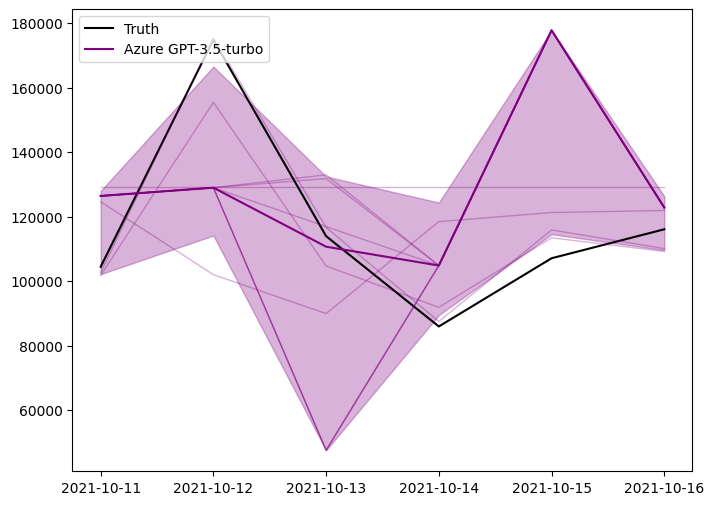

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt4_00', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


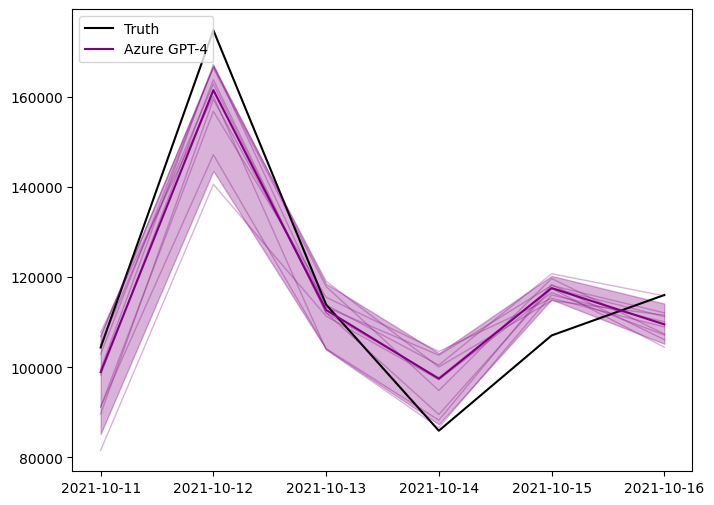

In [6]:
out = {}
for model in model_names:  # GPT-4 takes a about a minute to run
    model_hypers[model].update({"dataset_name": "Kao"})  # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(
        gpt_client,
        train,
        test,
        hypers,
        num_samples,
        model_predict_fns[model],
        verbose=False,
        parallel=False,
    )
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)

# Consistency of result

In [7]:
result = {}
for model in model_names:
    result[model] = []
for _ in range(10):
    for model in model_names:  # GPT-4 takes a about a minute to run
        model_hypers[model].update({"dataset_name": "Kao"})  # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(
            gpt_client,
            train,
            test,
            hypers,
            num_samples,
            model_predict_fns[model],
            verbose=False,
            parallel=False,
        )
        result[model].append(pred_dict["median"].to_list())

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt35_00', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt4_00', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt35_00', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt4_00', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt35_00', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt4_00', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt35_00', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt4_00', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt35_00', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt4_00', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt35_00', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt4_00', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt35_00', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt4_00', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt35_00', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt4_00', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt35_00', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt4_00', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt35_00', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt4_00', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'Kao'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


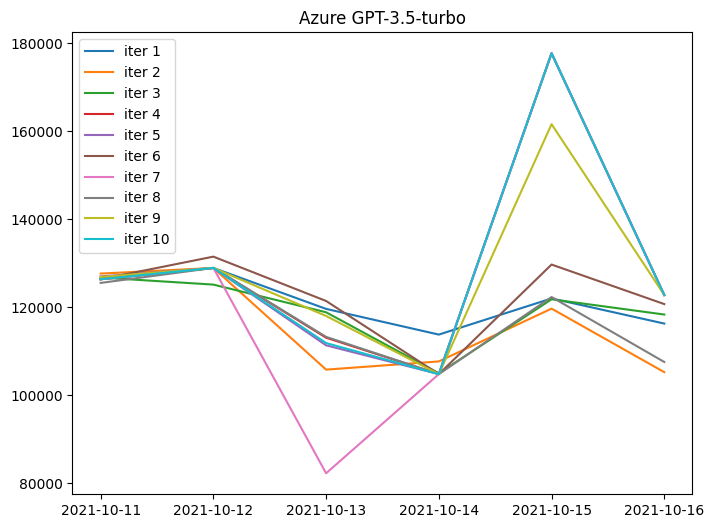

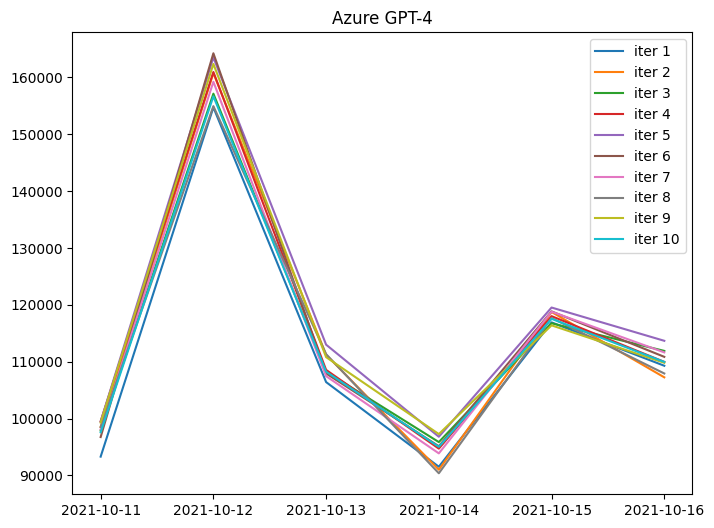

In [8]:
# plt.plot(train)
for item in result:
    plt.figure(figsize=(8, 6), dpi=100)
    plt.title(item)
    for i, pred in enumerate(result[item]):
        plt.plot(test.index, pred, label=f"iter {i + 1}")
    plt.legend()
    plt.show()